# AoU FHIR & OMOP Analysis
Information about Sync for Science and OMOP patients, and comparing the data of each.

First, define the locations of the data we wish to analyze and compare, and import the necessary modules.

In [1]:
import os
import omop_analyze
import fhir_analyze
import aou_analysis

current_directory = os.getcwd()
omop_directory = "\\omop\\20190823"
fhir_directory = "\\fhir\\Participant"

## FHIR Summary
pull in fhir data, let's find some basic data on the number of patients and number of entries retrived

In [2]:
fhir_patients = fhir_analyze.traverse_directory(current_directory+fhir_directory)

got 83 s4s participants


In [3]:
aou_analysis.fhir_plot_category_counts(fhir_patients)

# OMOP Summary
number of patients and records retrieved from OMOP CSVs

In [4]:
omop_patients, csvs = omop_analyze.parse_omop(path=current_directory+omop_directory)

Got 74 omop participants


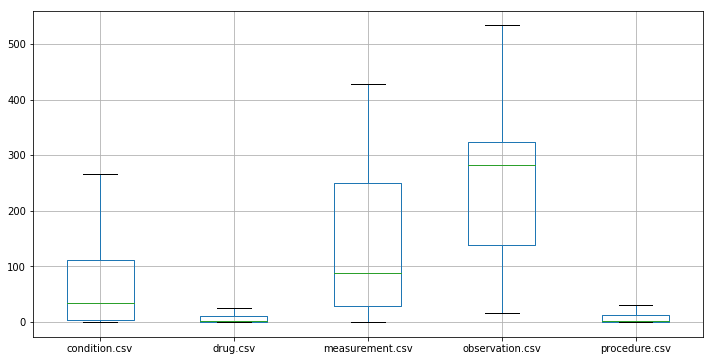

In [5]:
aou_analysis.omop_plot_category_counts(omop_patients, csvs)